# Epiroc Last-Mile Delivery Optimization - Exploratory Data Analysis

This notebook provides a comprehensive EDA of the last-mile delivery dataset to understand patterns, identify issues, and guide solution development for the hackathon.

## Objectives
1. Understand the dataset structure and quality
2. Analyze delivery performance metrics
3. Identify patterns and anomalies
4. Explore factors affecting on-time delivery
5. Generate insights for solution development


## 1. Setup and Data Loading


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


In [2]:
# Load the data (path relative to notebook location)
df = pd.read_csv('../Dataset/last-mile-data.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")


Dataset loaded successfully!
Shape: (72966, 20)

Columns: ['carrier_mode', 'actual_ship', 'actual_delivery', 'carrier_posted_service_days', 'customer_distance', 'truckload_service_days', 'all_modes_goal_transit_days', 'actual_transit_days', 'otd_designation', 'load_id_pseudo', 'carrier_pseudo', 'origin_zip_3d', 'dest_zip_3d', 'ship_dow', 'ship_week', 'ship_month', 'ship_year', 'lane_zip3_pair', 'lane_id', 'distance_bucket']


## 1.5. Data Cleaning


In [3]:
# Convert date columns first for proper filtering
df['actual_ship'] = pd.to_datetime(df['actual_ship'])
df['actual_delivery'] = pd.to_datetime(df['actual_delivery'])

# Data cleaning: Remove error rows
print("Data Cleaning:")
print("=" * 50)
initial_count = len(df)
print(f"Initial record count: {initial_count:,}")

# Remove rows with negative actual_transit_days (data quality issues)
negative_transit = df[df['actual_transit_days'] < 0]
df = df[df['actual_transit_days'] >= 0].copy()
print(f"\nRemoved {len(negative_transit):,} rows with negative transit days ({len(negative_transit)/initial_count*100:.2f}%)")

# Remove rows with zero distance (errors or in-house deliveries)
zero_distance = df[df['customer_distance'] == 0]
df = df[df['customer_distance'] > 0].copy()
print(f"Removed {len(zero_distance):,} rows with zero distance ({len(zero_distance)/initial_count*100:.2f}%)")

final_count = len(df)
print(f"\nFinal record count: {final_count:,}")
print(f"Total removed: {initial_count - final_count:,} rows ({(initial_count - final_count)/initial_count*100:.2f}%)")
print("=" * 50)


Data Cleaning:
Initial record count: 72,966

Removed 2 rows with negative transit days (0.00%)
Removed 198 rows with zero distance (0.27%)

Final record count: 72,766
Total removed: 200 rows (0.27%)


## 2. Data Overview and Basic Statistics


In [4]:
# Calculate transit days difference
df['transit_days_diff'] = df['actual_transit_days'] - df['all_modes_goal_transit_days']

print("Date range:")
print(f"  From: {df['actual_ship'].min()}")
print(f"  To: {df['actual_ship'].max()}")
print(f"  Total days: {(df['actual_ship'].max() - df['actual_ship'].min()).days}")


Date range:
  From: 2022-01-03 09:45:00
  To: 2025-08-29 17:39:00
  Total days: 1334


## 2. Data Overview and Basic Statistics


In [5]:
# Convert date columns
df['actual_ship'] = pd.to_datetime(df['actual_ship'])
df['actual_delivery'] = pd.to_datetime(df['actual_delivery'])

# Calculate transit days difference
df['transit_days_diff'] = df['actual_transit_days'] - df['all_modes_goal_transit_days']

print("Date range:")
print(f"  From: {df['actual_ship'].min()}")
print(f"  To: {df['actual_ship'].max()}")
print(f"  Total days: {(df['actual_ship'].max() - df['actual_ship'].min()).days}")


Date range:
  From: 2022-01-03 09:45:00
  To: 2025-08-29 17:39:00
  Total days: 1334


In [6]:
# Missing values
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing Values:")
    print(missing_df)
else:
    print("No missing values!")


Missing Values:
                             Missing Count  Missing %
truckload_service_days               69127      95.00
carrier_posted_service_days           3639       5.00


In [7]:
# First few rows
df.head(10)


,carrier_mode,actual_ship,actual_delivery,carrier_posted_service_days,customer_distance,truckload_service_days,all_modes_goal_transit_days,actual_transit_days,otd_designation,load_id_pseudo,carrier_pseudo,origin_zip_3d,dest_zip_3d,ship_dow,ship_week,ship_month,ship_year,lane_zip3_pair,lane_id,distance_bucket,transit_days_diff
0,Truckload,2022-01-03 09:45:00,2022-01-05 09:00:00,NaN,275,1.00,1,2,Late,786caec8eb1b,19936bf01cc6,441xx,172xx,0,1,1,2022,441xx→172xx,109c918ef6db,250-500,1
1,Truckload,2022-01-03 09:45:00,2022-01-03 10:30:00,NaN,104,1.00,1,0,Delivered Early,b46e80cc7d74,19936bf01cc6,212xx,172xx,0,1,1,2022,212xx→172xx,8ce447819210,100-250,-1
2,Truckload,2022-01-03 10:45:00,2022-01-04 14:00:00,NaN,791,2.00,2,1,Delivered Early,6bbe5e8028ce,54874e5091dc,617xx,750xx,0,1,1,2022,617xx→750xx,fea9f01cb177,500-1k,-1
3,Truckload,2022-01-03 11:00:00,2022-01-04 15:00:00,NaN,791,2.00,2,1,Delivered Early,e383da06fae4,54874e5091dc,617xx,750xx,0,1,1,2022,617xx→750xx,fea9f01cb177,500-1k,-1
4,Truckload,2022-01-03 12:30:00,2022-01-04 11:00:00,NaN,496,1.00,1,1,On Time,edb8ef7622a2,dbfc03065eae,441xx,280xx,0,1,1,2022,441xx→280xx,f6f21727d3e8,250-500,0
5,Truckload,2022-01-03 12:30:00,2022-01-04 10:30:00,NaN,214,1.00,1,1,On Time,e8c185540206,19936bf01cc6,088xx,172xx,0,1,1,2022,NE→NE,022089c6f88a,100-250,0
6,LTL,2022-01-03 12:43:00,2022-01-04 13:48:00,1.00,53,NaN,1,1,On Time,283a3b7ae9c6,de78ac80b8a6,155xx,172xx,0,1,1,2022,155xx→172xx,c14b9c97a77b,0-100,0
7,LTL,2022-01-03 12:54:00,2022-01-06 13:39:00,3.00,1358,NaN,3,3,On Time,17ba7a9b18e2,de78ac80b8a6,750xx,172xx,0,1,1,2022,750xx→172xx,306c2c9f4f41,1k-2k,0
8,LTL,2022-01-03 13:14:00,2022-01-05 12:46:00,3.00,1096,NaN,3,2,Delivered Early,775966e9101f,0e32a59c0c8e,492xx,750xx,0,1,1,2022,492xx→750xx,d259c8421ac0,1k-2k,-1
9,Truckload,2022-01-03 13:30:00,2022-01-05 11:15:00,NaN,1268,3.00,3,2,Delivered Early,a5352c97cfa5,dbfc03065eae,441xx,770xx,0,1,1,2022,441xx→770xx,e1c226aff945,1k-2k,-1


## 3. Key Performance Metrics


In [8]:
# OTD Status Distribution
otd_counts = df['otd_designation'].value_counts()
otd_pct = df['otd_designation'].value_counts(normalize=True) * 100

print("On-Time Delivery (OTD) Status:")
print("=" * 50)
for status in otd_counts.index:
    print(f"{status:20s}: {otd_counts[status]:6,} ({otd_pct[status]:5.2f}%)")

print(f"\n{'='*50}")
print(f"On-Time Rate: {otd_pct.get('On Time', 0):.2f}%")
print(f"Late Rate: {otd_pct.get('Late', 0):.2f}%")
print(f"Early Rate: {otd_pct.get('Delivered Early', 0):.2f}%")


On-Time Delivery (OTD) Status:
On Time             : 46,507 (63.91%)
Late                : 13,935 (19.15%)
Delivered Early     : 12,324 (16.94%)

On-Time Rate: 63.91%
Late Rate: 19.15%
Early Rate: 16.94%


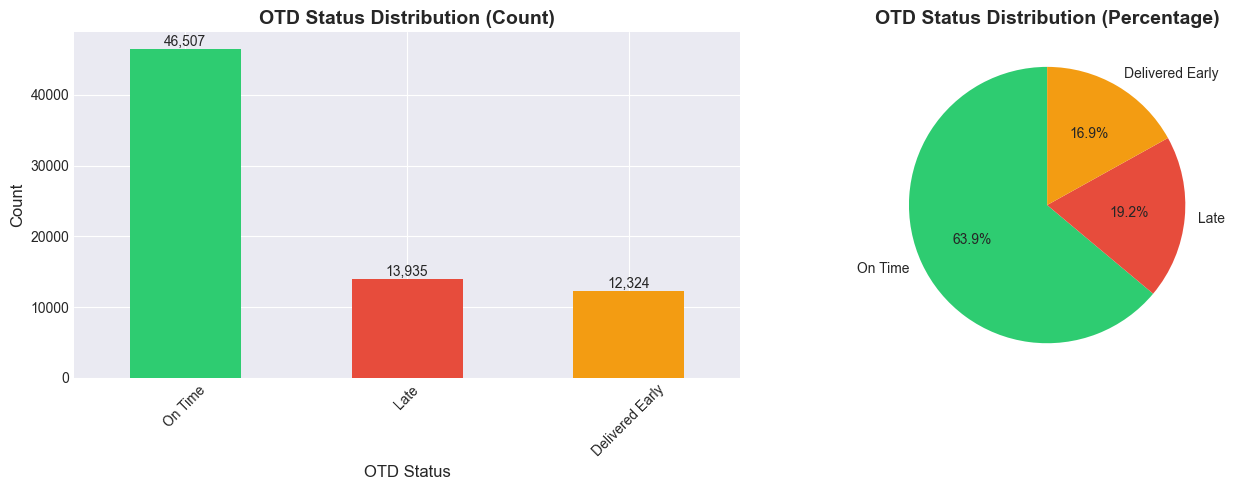

In [9]:
# Visualize OTD Status
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
otd_counts.plot(kind='bar', ax=axes[0], color=['#2ecc71', '#e74c3c', '#f39c12'])
axes[0].set_title('OTD Status Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('OTD Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for i, v in enumerate(otd_counts.values):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Pie chart
otd_pct.plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90, 
             colors=['#2ecc71', '#e74c3c', '#f39c12'])
axes[1].set_title('OTD Status Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [10]:
# Transit Days Analysis
print("Transit Days Statistics:")
print("=" * 50)
print(f"Actual Transit Days:")
print(df['actual_transit_days'].describe())
print(f"\nGoal Transit Days:")
print(df['all_modes_goal_transit_days'].describe())
print(f"\nDifference (Actual - Goal):")
print(df['transit_days_diff'].describe())


Transit Days Statistics:
Actual Transit Days:
count   72766.00
mean        2.92
std         1.79
min         0.00
25%         2.00
50%         3.00
75%         4.00
max        69.00
Name: actual_transit_days, dtype: float64

Goal Transit Days:
count   72766.00
mean        2.79
std         1.38
min         1.00
25%         2.00
50%         3.00
75%         4.00
max        11.00
Name: all_modes_goal_transit_days, dtype: float64

Difference (Actual - Goal):
count   72766.00
mean        0.13
std         1.45
min        -9.00
25%         0.00
50%         0.00
75%         0.00
max        67.00
Name: transit_days_diff, dtype: float64


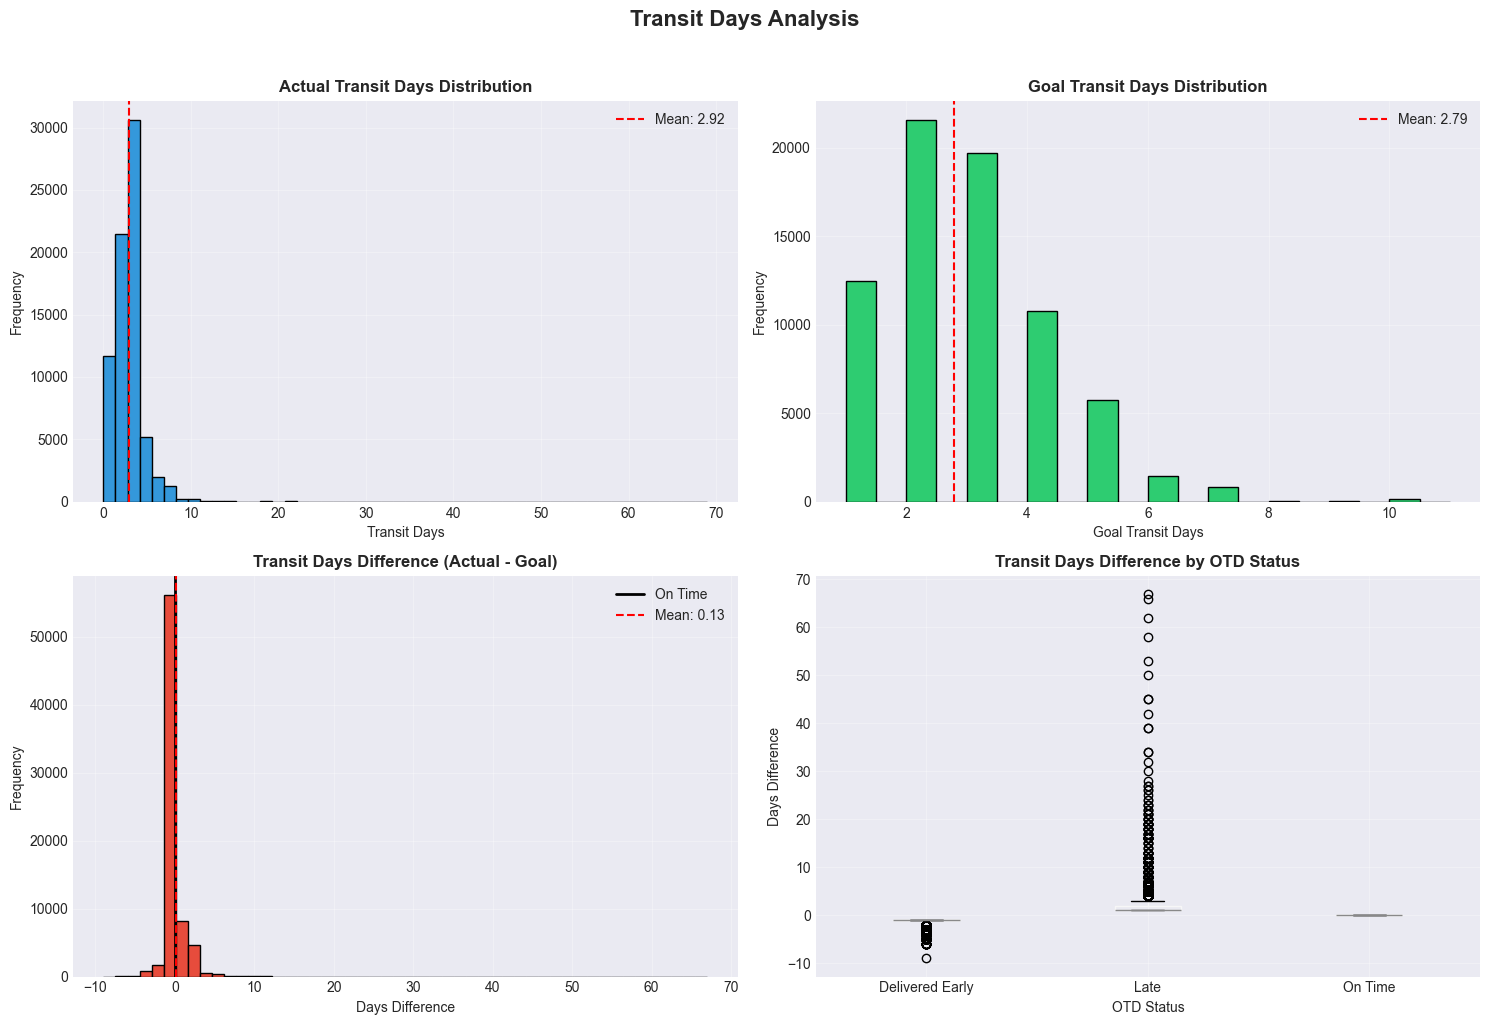

In [11]:
# Visualize Transit Days Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Actual Transit Days
axes[0, 0].hist(df['actual_transit_days'], bins=50, color='#3498db', edgecolor='black')
axes[0, 0].axvline(df['actual_transit_days'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["actual_transit_days"].mean():.2f}')
axes[0, 0].set_title('Actual Transit Days Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Transit Days')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Goal Transit Days
axes[0, 1].hist(df['all_modes_goal_transit_days'], bins=20, color='#2ecc71', edgecolor='black')
axes[0, 1].axvline(df['all_modes_goal_transit_days'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["all_modes_goal_transit_days"].mean():.2f}')
axes[0, 1].set_title('Goal Transit Days Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Goal Transit Days')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Difference Distribution
axes[1, 0].hist(df['transit_days_diff'], bins=50, color='#e74c3c', edgecolor='black')
axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=2, label='On Time')
axes[1, 0].axvline(df['transit_days_diff'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["transit_days_diff"].mean():.2f}')
axes[1, 0].set_title('Transit Days Difference (Actual - Goal)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Days Difference')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Box plot by OTD Status
df.boxplot(column='transit_days_diff', by='otd_designation', ax=axes[1, 1])
axes[1, 1].set_title('Transit Days Difference by OTD Status', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('OTD Status')
axes[1, 1].set_ylabel('Days Difference')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Transit Days Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 4. Carrier Mode Analysis


In [12]:
# Carrier Mode Distribution
print("Carrier Mode Distribution:")
print("=" * 50)
mode_counts = df['carrier_mode'].value_counts()
mode_pct = df['carrier_mode'].value_counts(normalize=True) * 100

for mode in mode_counts.index:
    print(f"{mode:15s}: {mode_counts[mode]:6,} ({mode_pct[mode]:5.2f}%)")


Carrier Mode Distribution:
LTL            : 69,127 (95.00%)
Truckload      :  2,407 ( 3.31%)
TL Flatbed     :    837 ( 1.15%)
TL Dry         :    395 ( 0.54%)


In [13]:
# OTD Performance by Carrier Mode
otd_by_mode = pd.crosstab(df['carrier_mode'], df['otd_designation'], normalize='index') * 100
print("OTD Performance by Carrier Mode (%):")
print("=" * 50)
print(otd_by_mode.round(2))


OTD Performance by Carrier Mode (%):
otd_designation  Delivered Early  Late  On Time
carrier_mode                                   
LTL                        14.83 19.82    65.35
TL Dry                     70.63  3.04    26.33
TL Flatbed                 59.74  5.73    34.53
Truckload                  53.80  7.10    39.09


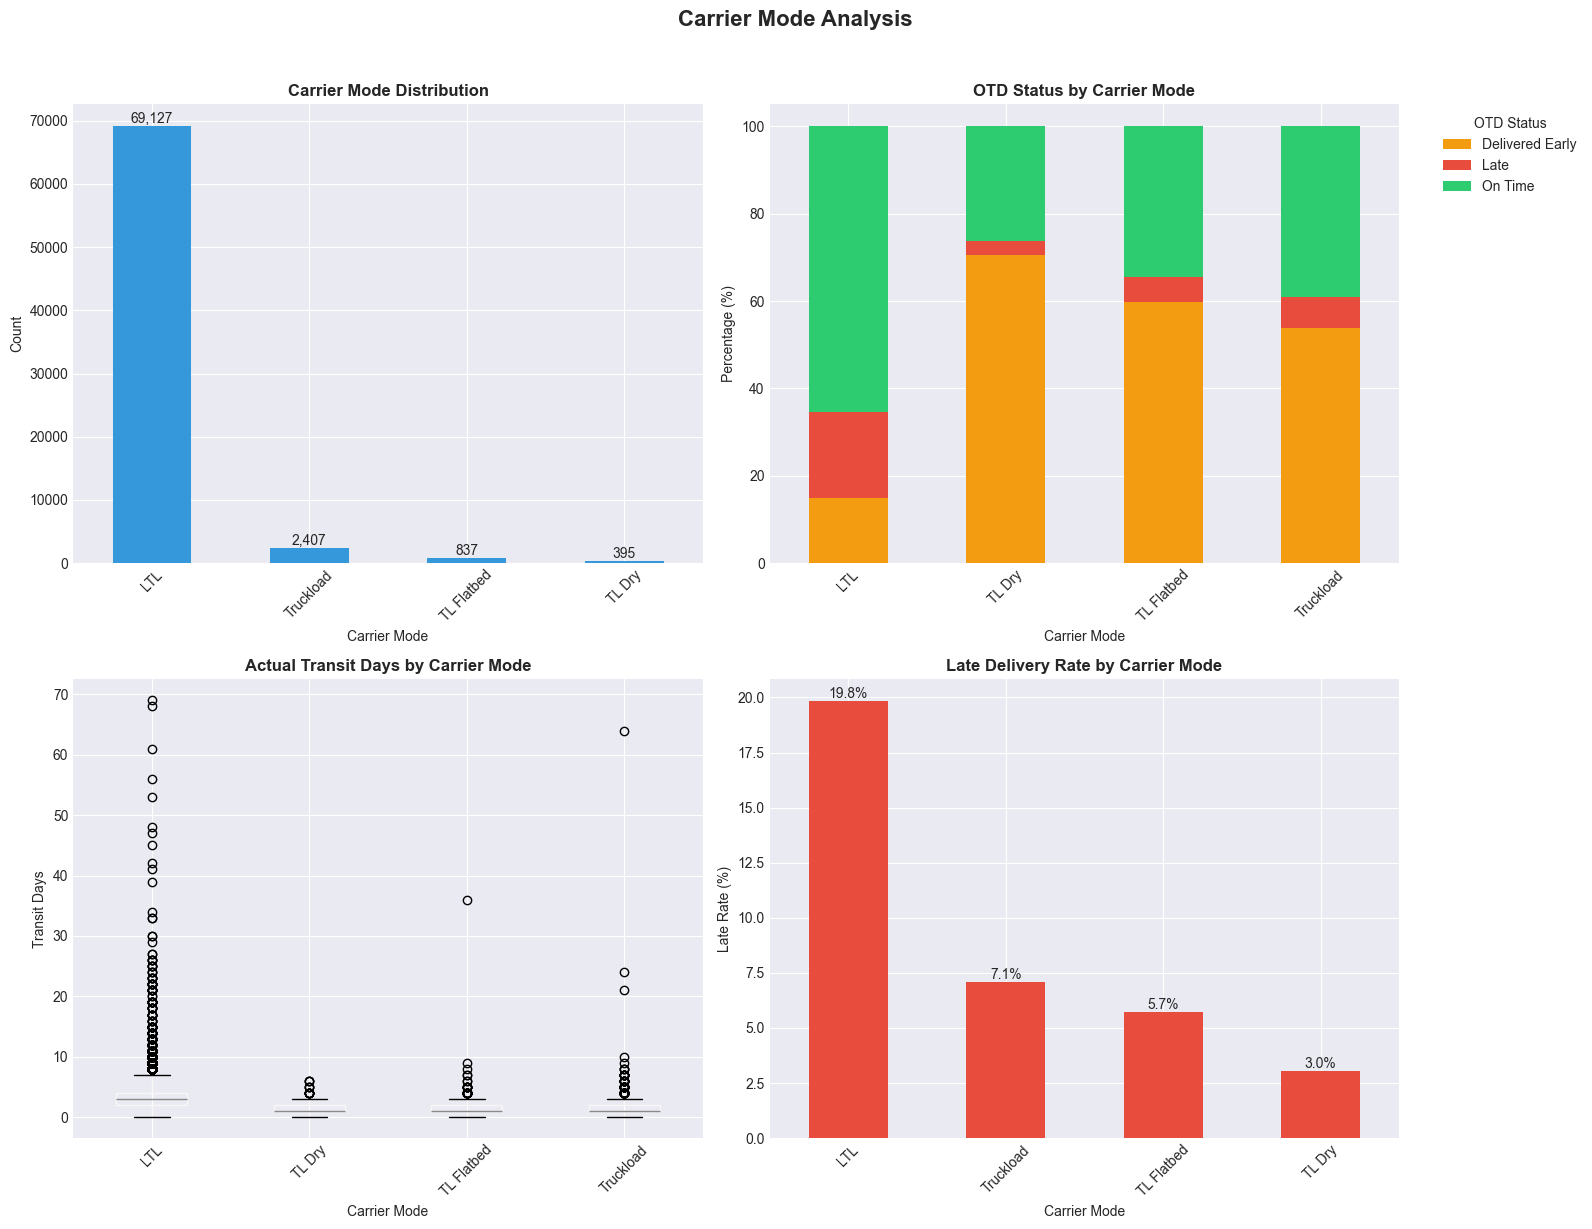

In [14]:
# Visualize Carrier Mode Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Carrier Mode Distribution
mode_counts.plot(kind='bar', ax=axes[0, 0], color='#3498db')
axes[0, 0].set_title('Carrier Mode Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Carrier Mode')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(mode_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# OTD by Mode - Stacked Bar
otd_by_mode.plot(kind='bar', stacked=True, ax=axes[0, 1], 
                  color=['#f39c12', '#e74c3c', '#2ecc71'])
axes[0, 1].set_title('OTD Status by Carrier Mode', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Carrier Mode')
axes[0, 1].set_ylabel('Percentage (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend(title='OTD Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Transit Days by Mode
df.boxplot(column='actual_transit_days', by='carrier_mode', ax=axes[1, 0])
axes[1, 0].set_title('Actual Transit Days by Carrier Mode', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Carrier Mode')
axes[1, 0].set_ylabel('Transit Days')
axes[1, 0].tick_params(axis='x', rotation=45)

# Late Delivery Rate by Mode
late_by_mode = df.groupby('carrier_mode')['otd_designation'].apply(
    lambda x: (x == 'Late').sum() / len(x) * 100
).sort_values(ascending=False)
late_by_mode.plot(kind='bar', ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_title('Late Delivery Rate by Carrier Mode', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Carrier Mode')
axes[1, 1].set_ylabel('Late Rate (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(late_by_mode.values):
    axes[1, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.suptitle('Carrier Mode Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 5. Distance Analysis


In [15]:
# Distance Statistics
print("Distance Analysis:")
print("=" * 50)
print(f"Customer Distance Statistics:")
print(df['customer_distance'].describe())
print(f"\nDistance Buckets:")
print(df['distance_bucket'].value_counts().sort_index())


Distance Analysis:
Customer Distance Statistics:
count   72766.00
mean     1024.25
std       648.71
min         1.00
25%       496.00
50%       975.00
75%      1408.00
max      3917.00
Name: customer_distance, dtype: float64

Distance Buckets:
distance_bucket
0-100       2441
100-250     4930
1k-2k      25409
250-500    10913
2k+         8045
500-1k     21028
Name: count, dtype: int64


In [16]:
# OTD Performance by Distance
otd_by_distance = pd.crosstab(df['distance_bucket'], df['otd_designation'], normalize='index') * 100
print("OTD Performance by Distance Bucket (%):")
print("=" * 50)
print(otd_by_distance.round(2))


OTD Performance by Distance Bucket (%):
otd_designation  Delivered Early  Late  On Time
distance_bucket                                
0-100                      11.63 13.36    75.01
100-250                     7.55 28.68    63.77
1k-2k                      20.40 15.07    64.53
250-500                    10.24 26.62    63.14
2k+                        34.41  9.10    56.49
500-1k                     12.36 22.49    65.15


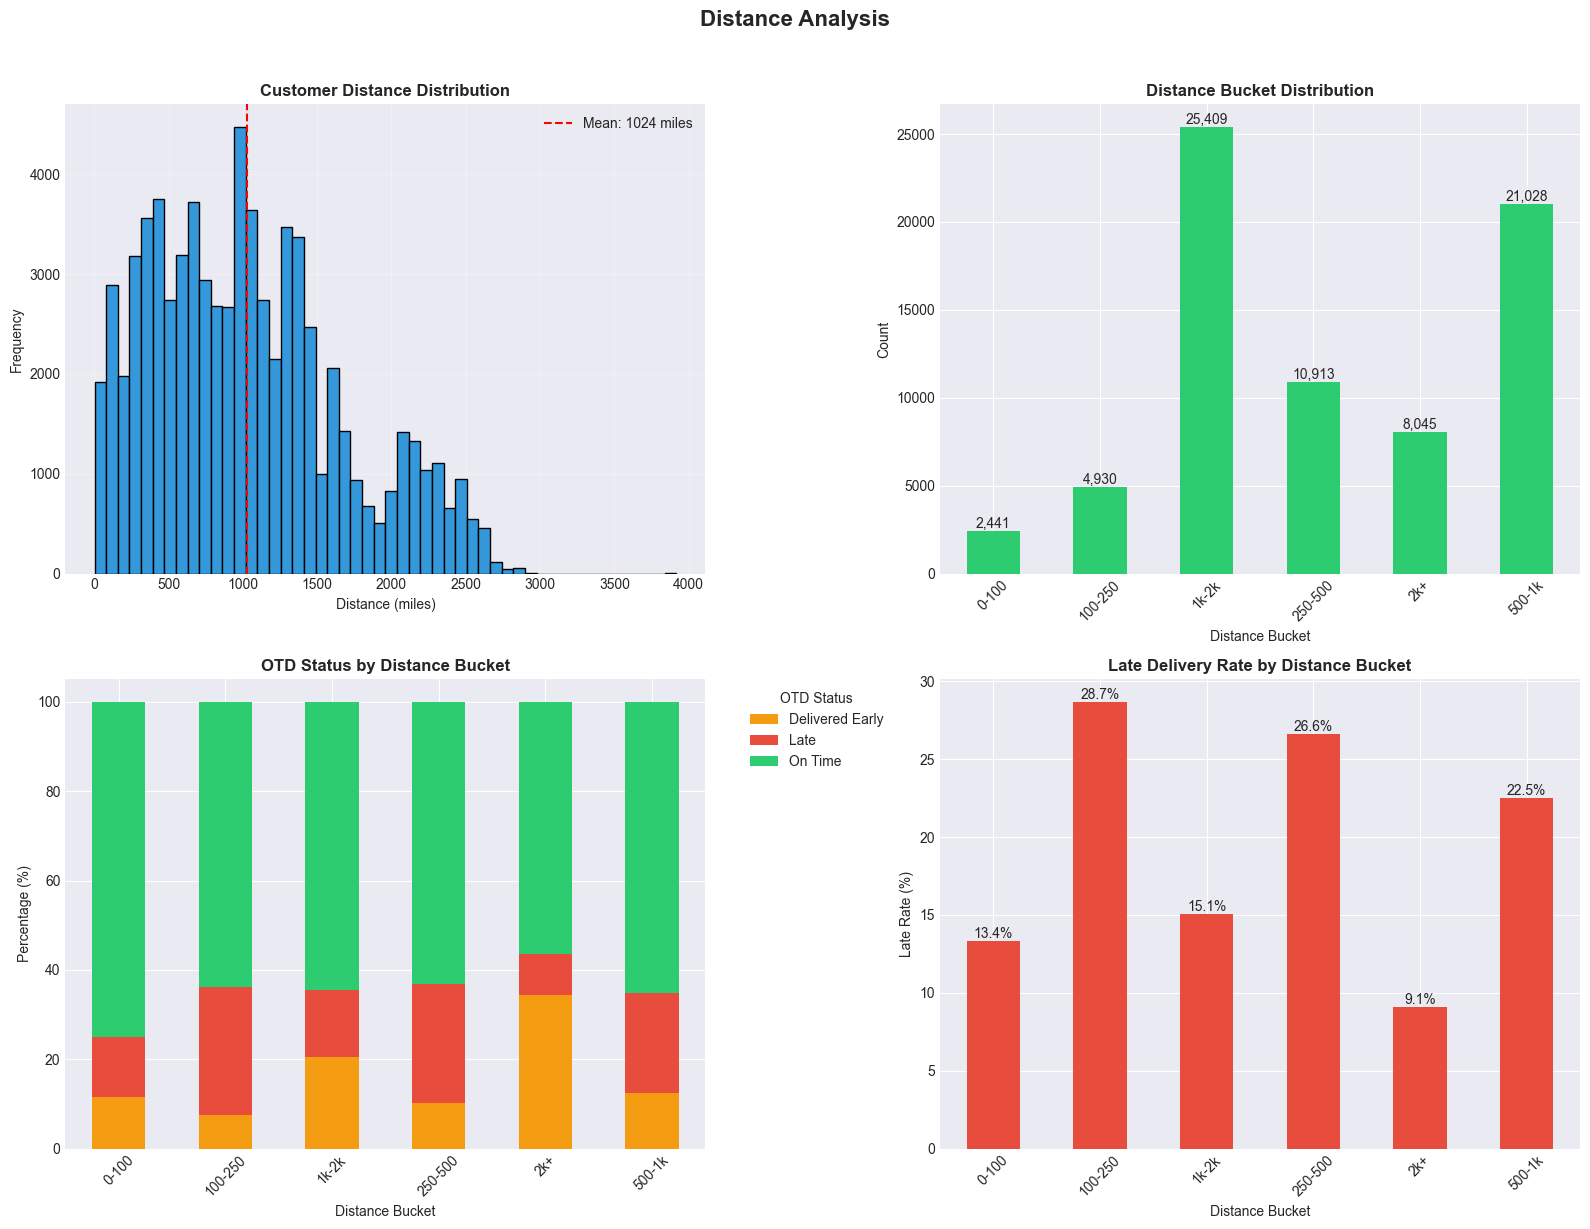

In [17]:
# Visualize Distance Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Distance Distribution
axes[0, 0].hist(df['customer_distance'], bins=50, color='#3498db', edgecolor='black')
axes[0, 0].axvline(df['customer_distance'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {df["customer_distance"].mean():.0f} miles')
axes[0, 0].set_title('Customer Distance Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Distance (miles)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Distance Buckets
distance_bucket_counts = df['distance_bucket'].value_counts().sort_index()
distance_bucket_counts.plot(kind='bar', ax=axes[0, 1], color='#2ecc71')
axes[0, 1].set_title('Distance Bucket Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Distance Bucket')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(distance_bucket_counts.values):
    axes[0, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

# OTD by Distance - Stacked Bar
otd_by_distance.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                     color=['#f39c12', '#e74c3c', '#2ecc71'])
axes[1, 0].set_title('OTD Status by Distance Bucket', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Distance Bucket')
axes[1, 0].set_ylabel('Percentage (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend(title='OTD Status', bbox_to_anchor=(1.05, 1), loc='upper left')

# Late Rate by Distance
late_by_distance = df.groupby('distance_bucket')['otd_designation'].apply(
    lambda x: (x == 'Late').sum() / len(x) * 100
).sort_index()
late_by_distance.plot(kind='bar', ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_title('Late Delivery Rate by Distance Bucket', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Distance Bucket')
axes[1, 1].set_ylabel('Late Rate (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(late_by_distance.values):
    axes[1, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom')

plt.suptitle('Distance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 6. Time-Based Patterns


In [18]:
# Time-based Analysis
print("Time-Based Patterns:")
print("=" * 50)
print(f"\nShip Year Distribution:")
print(df['ship_year'].value_counts().sort_index())
print(f"\nShip Month Distribution:")
print(df['ship_month'].value_counts().sort_index())
print(f"\nShip Day of Week (0=Monday, 6=Sunday):")
dow_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
dow_counts = df['ship_dow'].value_counts().sort_index()
for dow, count in dow_counts.items():
    print(f"  {dow_map.get(dow, dow):10s}: {count:6,}")


Time-Based Patterns:

Ship Year Distribution:
ship_year
2022    20485
2023    20899
2024    19595
2025    11787
Name: count, dtype: int64

Ship Month Distribution:
ship_month
1     5959
2     5912
3     7219
4     7274
5     6970
6     6859
7     6828
8     6963
9     4921
10    5344
11    4231
12    4286
Name: count, dtype: int64

Ship Day of Week (0=Monday, 6=Sunday):
  Monday    : 13,944
  Tuesday   : 14,424
  Wednesday : 14,730
  Thursday  : 14,805
  Friday    : 14,850
  Saturday  :     11
  Sunday    :      2


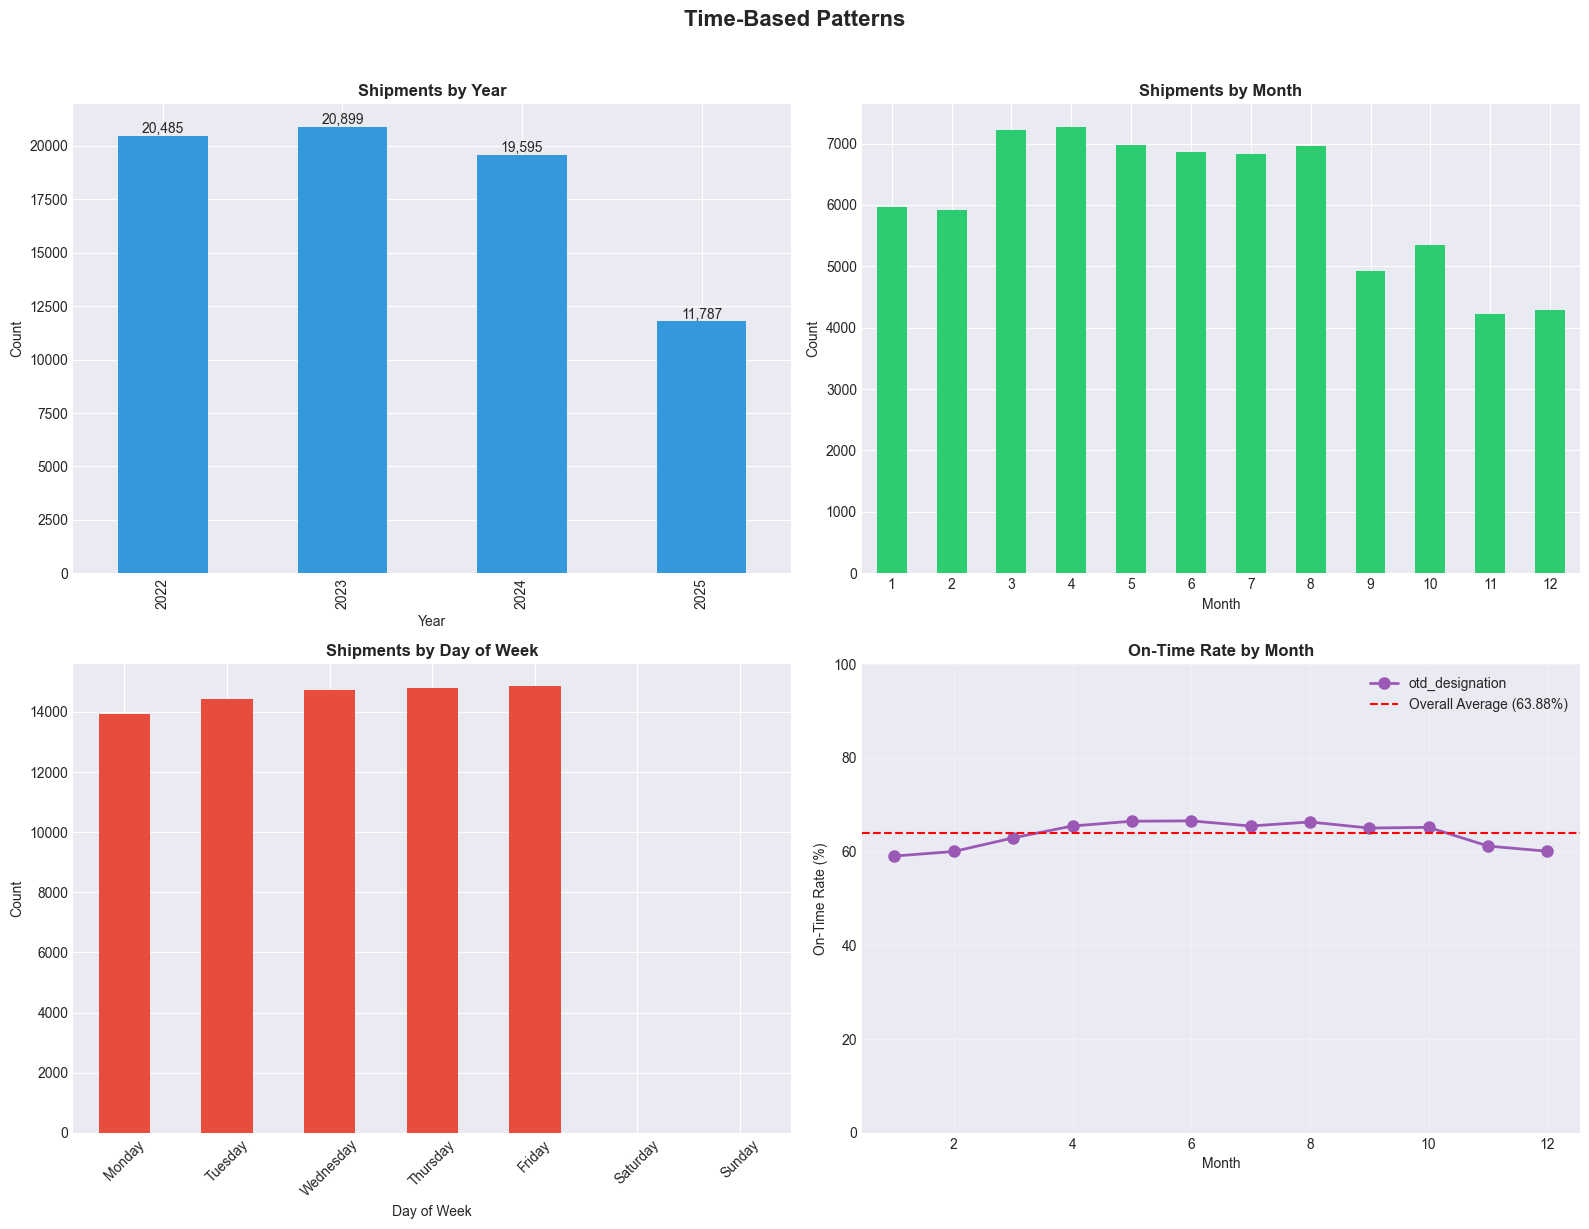

In [19]:
# Visualize Time-Based Patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Year Distribution
year_counts = df['ship_year'].value_counts().sort_index()
year_counts.plot(kind='bar', ax=axes[0, 0], color='#3498db')
axes[0, 0].set_title('Shipments by Year', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Count')
for i, v in enumerate(year_counts.values):
    axes[0, 0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Month Distribution
month_counts = df['ship_month'].value_counts().sort_index()
month_counts.plot(kind='bar', ax=axes[0, 1], color='#2ecc71')
axes[0, 1].set_title('Shipments by Month', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=0)

# Day of Week Distribution
dow_counts = df['ship_dow'].value_counts().sort_index()
dow_labels = [dow_map.get(i, f'Day {i}') for i in dow_counts.index]
dow_counts.plot(kind='bar', ax=axes[1, 0], color='#e74c3c')
axes[1, 0].set_title('Shipments by Day of Week', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xticklabels(dow_labels, rotation=45)

# OTD Rate by Month
otd_by_month = df.groupby('ship_month')['otd_designation'].apply(
    lambda x: (x == 'On Time').sum() / len(x) * 100
).sort_index()
otd_by_month.plot(kind='line', ax=axes[1, 1], marker='o', color='#9b59b6', linewidth=2, markersize=8)
axes[1, 1].axhline(y=63.88, color='red', linestyle='--', label='Overall Average (63.88%)')
axes[1, 1].set_title('On-Time Rate by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('On-Time Rate (%)')
axes[1, 1].set_ylim([0, 100])
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.suptitle('Time-Based Patterns', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 7. Lane and Carrier Analysis


In [20]:
# Lane Analysis
print("Lane Analysis:")
print("=" * 50)
print(f"Total unique lanes: {df['lane_id'].nunique():,}")
print(f"Total unique lane pairs: {df['lane_zip3_pair'].nunique():,}")
print(f"\nTop 10 most frequent lanes:")
top_lanes = df['lane_zip3_pair'].value_counts().head(10)
for i, (lane, count) in enumerate(top_lanes.items(), 1):
    print(f"  {i:2d}. {lane:20s}: {count:6,} shipments")


Lane Analysis:
Total unique lanes: 969
Total unique lane pairs: 969

Top 10 most frequent lanes:
   1. 750xx→857xx         :  1,274 shipments
   2. 750xx→898xx         :  1,240 shipments
   3. 544xx→441xx         :  1,198 shipments
   4. 750xx→331xx         :  1,031 shipments
   5. 750xx→416xx         :    655 shipments
   6. 172xx→300xx         :    617 shipments
   7. 750xx→591xx         :    601 shipments
   8. 750xx→253xx         :    594 shipments
   9. 172xx→898xx         :    570 shipments
  10. 172xx→416xx         :    562 shipments


In [21]:
# Carrier Analysis
print("Carrier Analysis:")
print("=" * 50)
print(f"Total unique carriers: {df['carrier_pseudo'].nunique():,}")
print(f"\nTop 10 carriers by volume:")
top_carriers = df['carrier_pseudo'].value_counts().head(10)
for i, (carrier, count) in enumerate(top_carriers.items(), 1):
    pct = (count / len(df)) * 100
    print(f"  {i:2d}. {carrier:15s}: {count:6,} shipments ({pct:5.2f}%)")


Carrier Analysis:
Total unique carriers: 117

Top 10 carriers by volume:
   1. 0e32a59c0c8e   : 62,364 shipments (85.70%)
   2. ae9d1671f54a   :  2,379 shipments ( 3.27%)
   3. cfd59abc9d4b   :  1,308 shipments ( 1.80%)
   4. d29d021b03f6   :  1,004 shipments ( 1.38%)
   5. b8e932b33b01   :    703 shipments ( 0.97%)
   6. e6c81f092efd   :    693 shipments ( 0.95%)
   7. 5797a633da7c   :    568 shipments ( 0.78%)
   8. dbfc03065eae   :    438 shipments ( 0.60%)
   9. de78ac80b8a6   :    407 shipments ( 0.56%)
  10. e241c58d2bfc   :    371 shipments ( 0.51%)


In [22]:
# Carrier Performance Analysis
carrier_perf = df.groupby('carrier_pseudo').agg({
    'otd_designation': lambda x: (x == 'On Time').sum() / len(x) * 100,
    'load_id_pseudo': 'count',
    'actual_transit_days': 'mean',
    'transit_days_diff': 'mean'
}).round(2)
carrier_perf.columns = ['On_Time_Rate_%', 'Total_Shipments', 'Avg_Transit_Days', 'Avg_Delay_Days']
carrier_perf = carrier_perf.sort_values('Total_Shipments', ascending=False)

print("Top 10 Carriers Performance:")
print("=" * 80)
print(carrier_perf.head(10))


Top 10 Carriers Performance:
                On_Time_Rate_%  Total_Shipments  Avg_Transit_Days  \
carrier_pseudo                                                      
0e32a59c0c8e             65.69            62364              3.03   
ae9d1671f54a             74.02             2379              2.19   
cfd59abc9d4b             81.73             1308              1.85   
d29d021b03f6             38.65             1004              3.36   
b8e932b33b01             49.64              703              2.29   
e6c81f092efd             34.78              693              1.61   
5797a633da7c             59.33              568              3.24   
dbfc03065eae             36.07              438              1.53   
de78ac80b8a6             33.91              407              4.15   
e241c58d2bfc             53.10              371              1.92   

                Avg_Delay_Days  
carrier_pseudo                  
0e32a59c0c8e              0.16  
ae9d1671f54a             -0.06  
cfd59abc9d

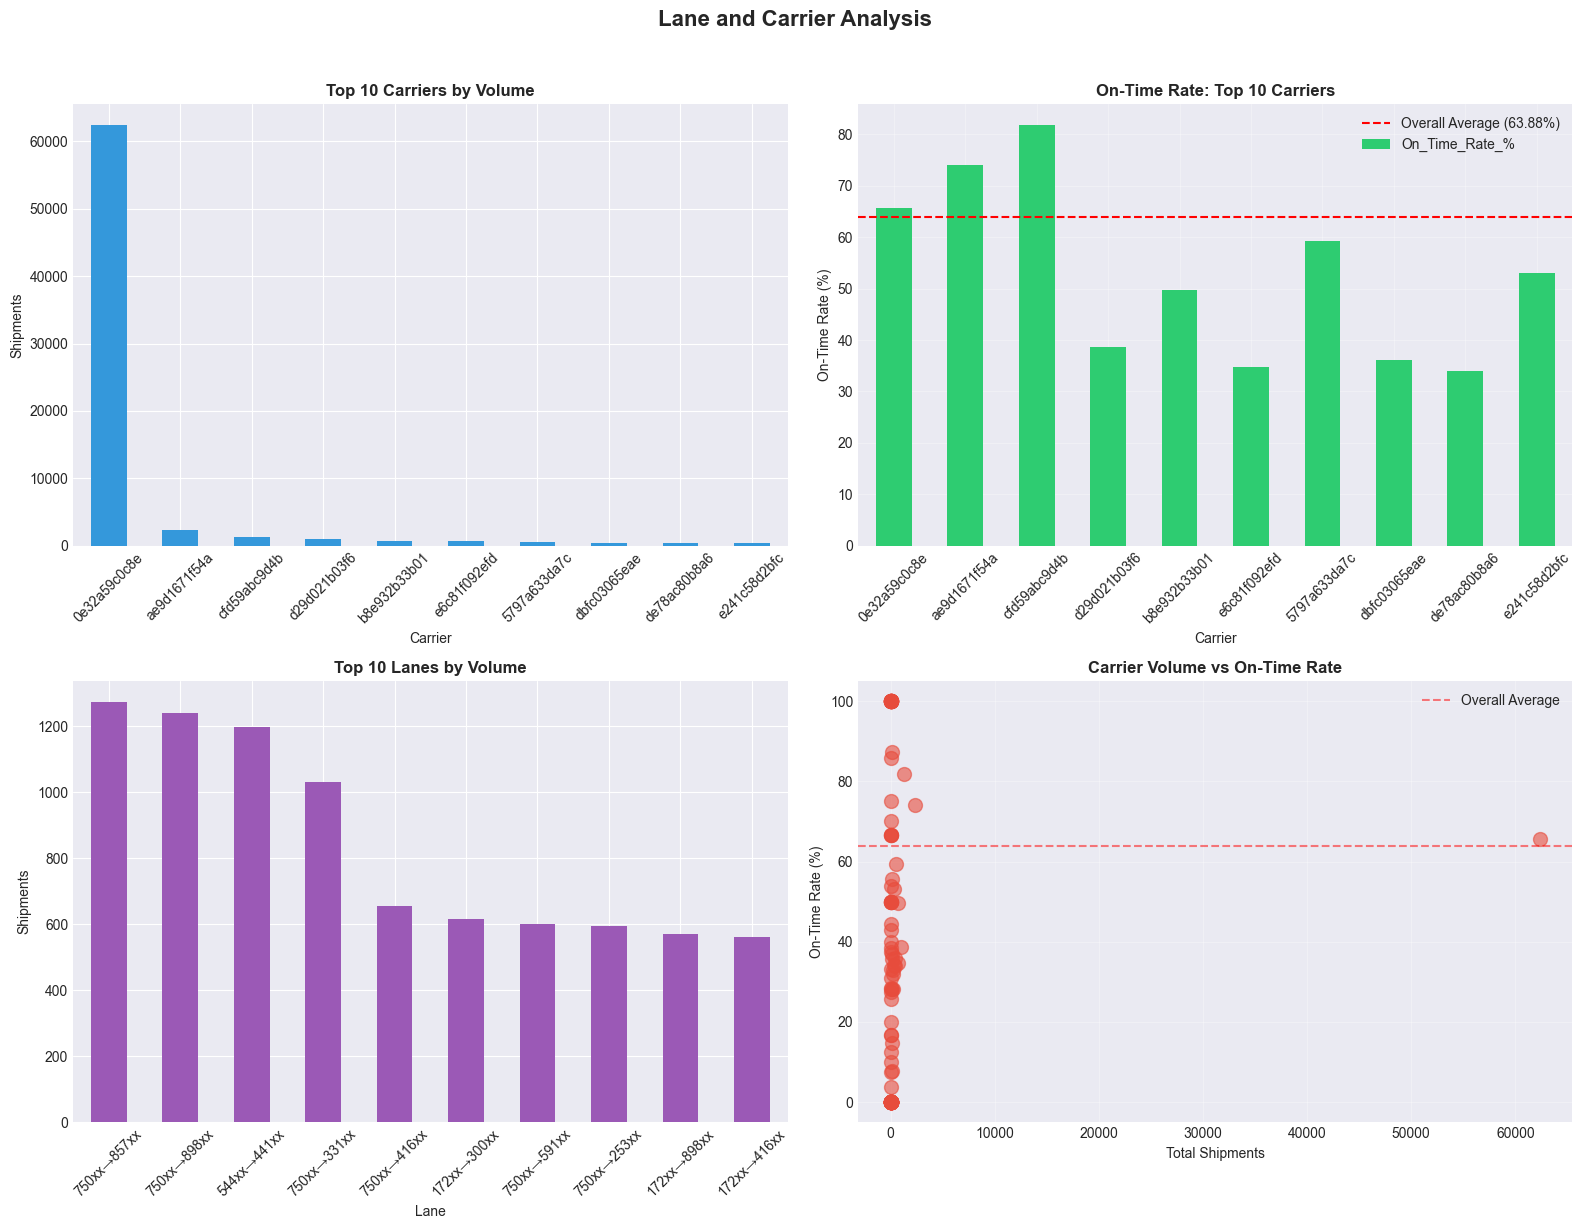

In [23]:
# Visualize Carrier Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top 10 Carriers by Volume
top_carriers.head(10).plot(kind='bar', ax=axes[0, 0], color='#3498db')
axes[0, 0].set_title('Top 10 Carriers by Volume', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Carrier')
axes[0, 0].set_ylabel('Shipments')
axes[0, 0].tick_params(axis='x', rotation=45)

# Top 10 Carriers On-Time Rate
top_carrier_perf = carrier_perf.head(10)
top_carrier_perf['On_Time_Rate_%'].plot(kind='bar', ax=axes[0, 1], color='#2ecc71')
axes[0, 1].axhline(y=63.88, color='red', linestyle='--', label='Overall Average (63.88%)')
axes[0, 1].set_title('On-Time Rate: Top 10 Carriers', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Carrier')
axes[0, 1].set_ylabel('On-Time Rate (%)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Top 10 Lanes by Volume
top_lanes.head(10).plot(kind='bar', ax=axes[1, 0], color='#9b59b6')
axes[1, 0].set_title('Top 10 Lanes by Volume', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Lane')
axes[1, 0].set_ylabel('Shipments')
axes[1, 0].tick_params(axis='x', rotation=45)

# Carrier Volume vs Performance
axes[1, 1].scatter(carrier_perf['Total_Shipments'], carrier_perf['On_Time_Rate_%'], 
                   alpha=0.6, s=100, color='#e74c3c')
axes[1, 1].axhline(y=63.88, color='red', linestyle='--', alpha=0.5, label='Overall Average')
axes[1, 1].set_title('Carrier Volume vs On-Time Rate', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Total Shipments')
axes[1, 1].set_ylabel('On-Time Rate (%)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Lane and Carrier Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 8. Anomaly Detection


In [24]:
# Identify Anomalies
print("Anomaly Detection:")
print("=" * 50)

# Negative transit days
negative_transit = df[df['actual_transit_days'] < 0]
print(f"\n1. Negative Transit Days: {len(negative_transit):,} records ({len(negative_transit)/len(df)*100:.2f}%)")
if len(negative_transit) > 0:
    print(f"   Min: {negative_transit['actual_transit_days'].min()} days")
    print(f"   Max: {negative_transit['actual_transit_days'].max()} days")

# Extreme delays
extreme_delays = df[df['transit_days_diff'] > 10]
print(f"\n2. Extreme Delays (>10 days): {len(extreme_delays):,} records ({len(extreme_delays)/len(df)*100:.2f}%)")
if len(extreme_delays) > 0:
    print(f"   Max delay: {extreme_delays['transit_days_diff'].max()} days")

# Very early deliveries
very_early = df[df['transit_days_diff'] < -5]
print(f"\n3. Very Early Deliveries (>5 days early): {len(very_early):,} records ({len(very_early)/len(df)*100:.2f}%)")
if len(very_early) > 0:
    print(f"   Most early: {very_early['transit_days_diff'].min()} days")

# Zero distance
zero_distance = df[df['customer_distance'] == 0]
print(f"\n4. Zero Distance Shipments: {len(zero_distance):,} records ({len(zero_distance)/len(df)*100:.2f}%)")


Anomaly Detection:

1. Negative Transit Days: 0 records (0.00%)

2. Extreme Delays (>10 days): 114 records (0.16%)
   Max delay: 67 days

3. Very Early Deliveries (>5 days early): 18 records (0.02%)
   Most early: -9 days

4. Zero Distance Shipments: 0 records (0.00%)


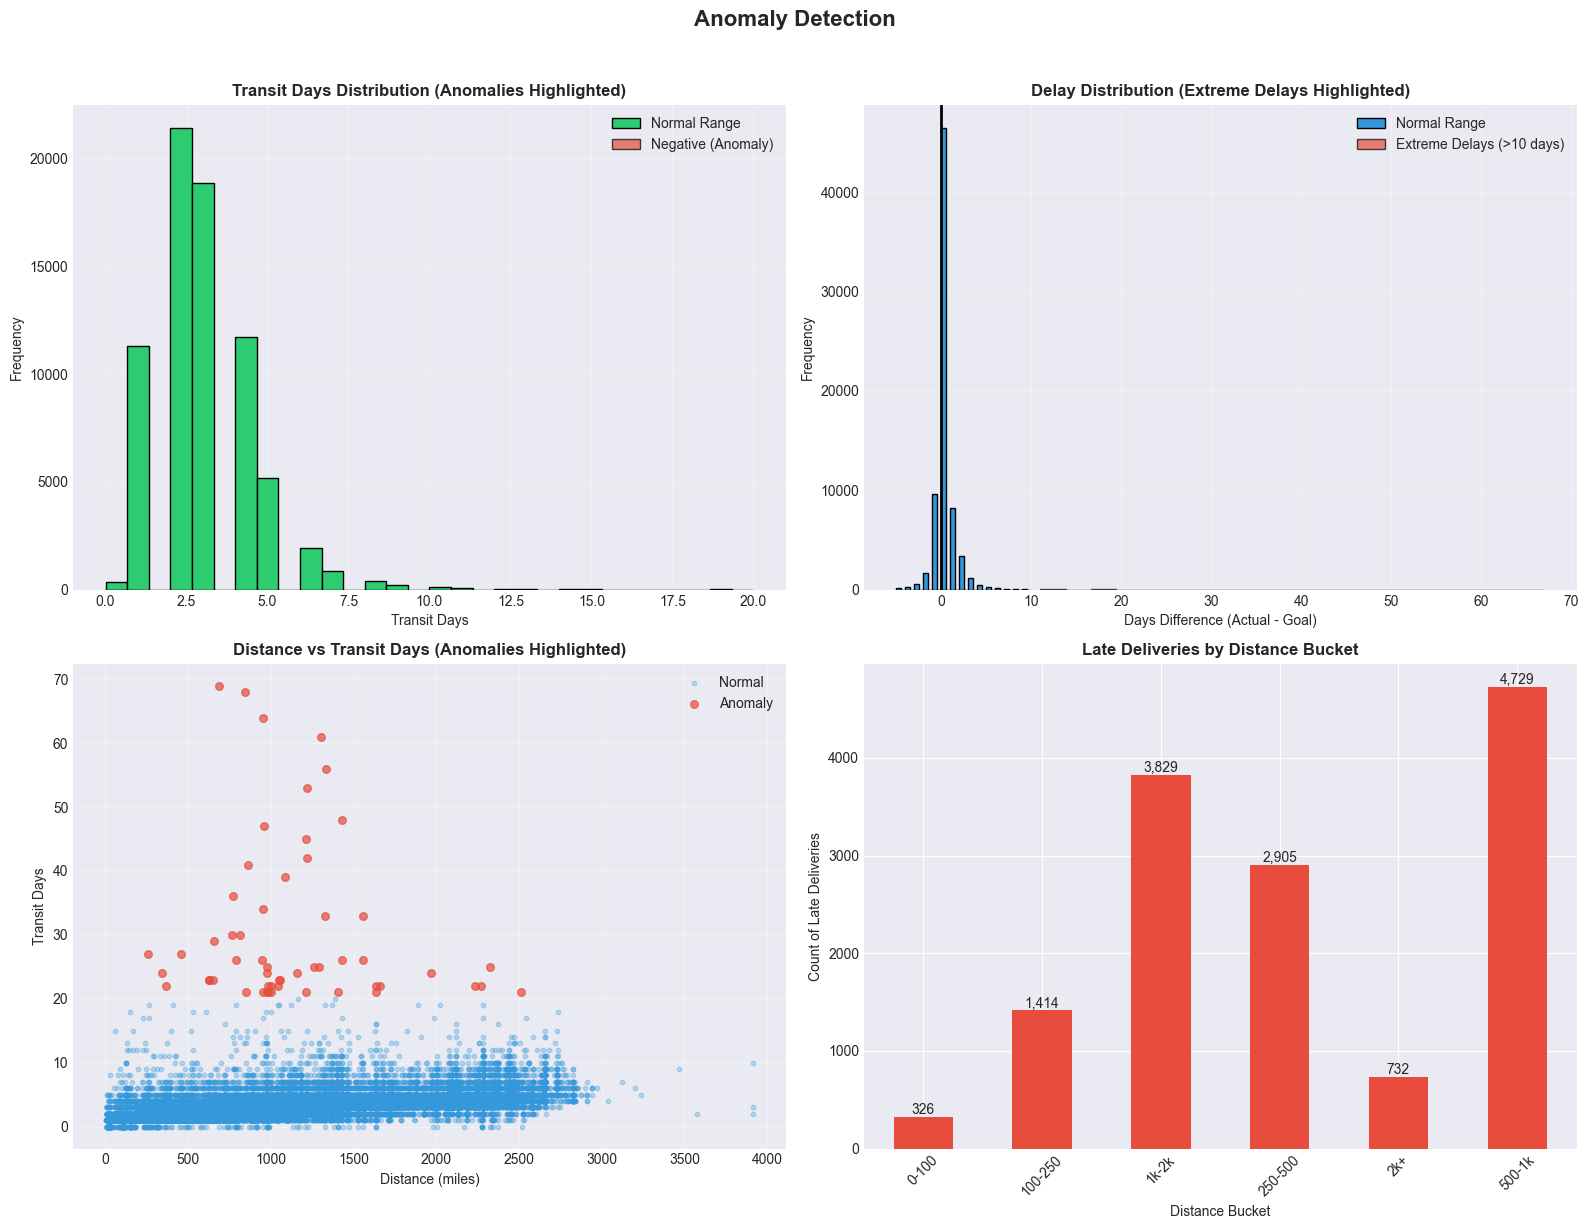

In [25]:
# Visualize Anomalies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Transit Days Distribution (zoomed)
normal_range = df[(df['actual_transit_days'] >= 0) & (df['actual_transit_days'] <= 20)]
axes[0, 0].hist(normal_range['actual_transit_days'], bins=30, color='#2ecc71', edgecolor='black', label='Normal Range')
axes[0, 0].hist(df[df['actual_transit_days'] < 0]['actual_transit_days'], bins=20, 
                color='#e74c3c', edgecolor='black', alpha=0.7, label='Negative (Anomaly)')
axes[0, 0].set_title('Transit Days Distribution (Anomalies Highlighted)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Transit Days')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Delay Distribution
normal_delays = df[(df['transit_days_diff'] >= -5) & (df['transit_days_diff'] <= 10)]
axes[0, 1].hist(normal_delays['transit_days_diff'], bins=30, color='#3498db', edgecolor='black', label='Normal Range')
extreme = df[df['transit_days_diff'] > 10]
if len(extreme) > 0:
    axes[0, 1].hist(extreme['transit_days_diff'], bins=20, color='#e74c3c', 
                    edgecolor='black', alpha=0.7, label='Extreme Delays (>10 days)')
axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=2)
axes[0, 1].set_title('Delay Distribution (Extreme Delays Highlighted)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Days Difference (Actual - Goal)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distance vs Transit Days (scatter with outliers)
normal_data = df[(df['actual_transit_days'] >= 0) & (df['actual_transit_days'] <= 20) & 
                 (df['customer_distance'] > 0)]
axes[1, 0].scatter(normal_data['customer_distance'], normal_data['actual_transit_days'], 
                   alpha=0.3, s=10, color='#3498db', label='Normal')
anomaly_data = df[(df['actual_transit_days'] < 0) | (df['actual_transit_days'] > 20)]
if len(anomaly_data) > 0:
    axes[1, 0].scatter(anomaly_data['customer_distance'], anomaly_data['actual_transit_days'], 
                       alpha=0.7, s=30, color='#e74c3c', label='Anomaly')
axes[1, 0].set_title('Distance vs Transit Days (Anomalies Highlighted)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Distance (miles)')
axes[1, 0].set_ylabel('Transit Days')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Late Deliveries by Distance Bucket
late_by_bucket = df[df['otd_designation'] == 'Late'].groupby('distance_bucket').size()
late_by_bucket.plot(kind='bar', ax=axes[1, 1], color='#e74c3c')
axes[1, 1].set_title('Late Deliveries by Distance Bucket', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Distance Bucket')
axes[1, 1].set_ylabel('Count of Late Deliveries')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(late_by_bucket.values):
    axes[1, 1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.suptitle('Anomaly Detection', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 9. Key Insights Summary


In [26]:
# Generate Summary Statistics
print("KEY INSIGHTS SUMMARY")
print("=" * 80)

print("\n1. OVERALL PERFORMANCE:")
print(f"   • On-Time Rate: {otd_pct.get('On Time', 0):.2f}%")
print(f"   • Late Rate: {otd_pct.get('Late', 0):.2f}% ({len(df[df['otd_designation'] == 'Late']):,} deliveries)")
print(f"   • Early Rate: {otd_pct.get('Delivered Early', 0):.2f}%")
print(f"   • Target: 95% Gross OTD (Current gap: {95 - otd_pct.get('On Time', 0):.2f} percentage points)")

print("\n2. CARRIER MODE INSIGHTS:")
print(f"   • LTL dominates: {mode_pct.get('LTL', 0):.2f}% of all shipments")
print(f"   • LTL late rate: {otd_by_mode.loc['LTL', 'Late']:.2f}%")
print(f"   • Truckload modes have lower late rates but often deliver early")

print("\n3. DISTANCE INSIGHTS:")
print(f"   • Average distance: {df['customer_distance'].mean():.0f} miles")
print(f"   • Medium distances (250-2k miles) most prone to delays")

print("\n4. CARRIER CONCENTRATION:")
top_carrier_pct = (top_carriers.iloc[0] / len(df)) * 100
print(f"   • Top carrier handles {top_carrier_pct:.1f}% of all shipments")
print(f"   • Total unique carriers: {df['carrier_pseudo'].nunique():,}")

print("\n5. LANE INSIGHTS:")
print(f"   • Total unique lanes: {df['lane_id'].nunique():,}")
print(f"   • Some high-volume lanes show recurring issues")

print("\n6. DATA QUALITY:")
print(f"   • Negative transit days: {len(negative_transit):,} records")
print(f"   • Extreme delays (>10 days): {len(extreme_delays):,} records")

print("\n7. OPPORTUNITIES FOR IMPROVEMENT:")
print("   • Focus on LTL optimization (95% of volume)")
print("   • Target medium-distance shipments for delay reduction")
print("   • Investigate high-volume lanes for recurring issues")
print("   • Monitor top carrier performance closely")
print("   • Improve ETA prediction accuracy")

print("\n" + "=" * 80)


KEY INSIGHTS SUMMARY

1. OVERALL PERFORMANCE:
   • On-Time Rate: 63.91%
   • Late Rate: 19.15% (13,935 deliveries)
   • Early Rate: 16.94%
   • Target: 95% Gross OTD (Current gap: 31.09 percentage points)

2. CARRIER MODE INSIGHTS:
   • LTL dominates: 95.00% of all shipments
   • LTL late rate: 19.82%
   • Truckload modes have lower late rates but often deliver early

3. DISTANCE INSIGHTS:
   • Average distance: 1024 miles
   • Medium distances (250-2k miles) most prone to delays

4. CARRIER CONCENTRATION:
   • Top carrier handles 85.7% of all shipments
   • Total unique carriers: 117

5. LANE INSIGHTS:
   • Total unique lanes: 969
   • Some high-volume lanes show recurring issues

6. DATA QUALITY:
   • Negative transit days: 0 records
   • Extreme delays (>10 days): 114 records

7. OPPORTUNITIES FOR IMPROVEMENT:
   • Focus on LTL optimization (95% of volume)
   • Target medium-distance shipments for delay reduction
   • Investigate high-volume lanes for recurring issues
   • Monitor t

## 10. Recommendations for Solution Development

### Prediction Models
- Build transit time prediction models considering:
  - Carrier mode
  - Distance and distance buckets
  - Lane-specific patterns
  - Temporal factors (day of week, month, season)
  - Carrier performance history

### Anomaly Detection
- Flag unusual patterns:
  - Negative transit days (data quality issues)
  - Extreme delays
  - Carrier-specific anomalies
  - Lane-specific issues

### UX Dashboard Features
- Interactive filtering by:
  - Carrier mode
  - Distance bucket
  - Lane
  - Time period
  - Carrier
- Visualizations for:
  - Performance trends
  - Anomaly alerts
  - Root cause analysis
  - Business impact metrics

### Business Impact Analysis
- Quantify:
  - Cost of delays
  - ROI of improvements
  - Prioritization of optimization initiatives
  - Carrier performance impact
